# Capstone Project: The Persuasive Power of Words

*by Nee Bimin*

## Notebook 3: Model Selection

In this notebook, we will run a few models to select the production model for testing in the next notebook.

## Content

- [Read Data](#Read-Data)
- [Persuasive Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Inspiring Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Unconvincing Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Multilabel Classifier](#Multilabel-Classifier)
    * [Train/Test Split](#Train/Test-Split)
    * [Linear SVC](#Linear-SVC)
    * [Naive Bayes](#Naive-Bayes)
    * [Logistic Regression](#Logistic-Regression)
- [Model Evaluation](#Model-Evaluation)
    * [Parsing Data](#Parsing-Data)
    * [Preprocessing](#Preprocessing)
- [Conclusion-and-Recommendations](#Conclusion-and-Recommendations)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Import libraries for modeling
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Import libraries for parsing html
import bs4 as bs 
import soupsieve as sv # Soup Sieve to parse using CSS selector
import codecs # To read in HTML file

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
# Read in data
ted_model = pd.read_csv('../data/ted_model.csv')

In [3]:
ted_model.head()

,comments,views,transcript,persuasive_label,inspiring_label,unconvincing_label
0,4553,47227110,good morning great ive blown away whole thing ...,1,1,1
1,265,3200520,thank much chris truly great honor opportunity...,1,1,1
2,124,1636292,hello voice mail old friend ive called tech su...,1,0,1
3,200,1697550,today im happy heard sustainable development s...,1,1,1
4,593,12005869,10 year ago took task teach global development...,1,1,1


As we can see, there are talks that have more than one label i.e. received at least the median number of votes for more than one type of rating. So we cannot train the model based on multi-class text classification. Rather we will train the model separately for each label to find out the common words in the talks that are voted persuasive, inspiring and unconvincing. 

After training the models separately for each label, we will compare their performance against multilabel classifiers.

## Persuasive Classifier

In [4]:
X = ted_model.transcript
y = ted_model.persuasive_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [5]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

0.5020337013364323

Here we find the baseline accuracy, which is the likelihood of a transcript having a higher than median number of persuasive votes, by calculating the percentage of the dataset that has the target value of 1. Normalising the value counts shows the percentage, and gives a baseline accuracy of 50.06%.

In [6]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb',MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [7]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [8]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [9]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                   'recall', 'precision', 'f1-score'])
gs_results.head()

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score


In [ ]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 

    model_results = {}

    gs.fit(X_train, y_train)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_

    print(gs.score(X_train, y_train), '\n')
    model_results['train_accuracy'] = gs.score(X_train, y_train)
    
    print(gs.score(X_test, y_test), '\n')
    model_results['test_accuracy'] = gs.score(X_test, y_test)
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
0.821615339918652 

0.6869918699186992 

True Negatives: 158
False Positives: 209
False Negatives: 22
True Positives: 349 

Model:  svm
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
1.0 

0.7235772357723578 

True Negatives: 225
False Positives: 142
False Negatives: 62
True Positives: 309 



In [ ]:
gs_results.sort_values('test_accuracy', ascending=False)

Support Vector Machine performed the best based on test set accuracy, our main metric. It is closely followed by Logistic Regression. While Naive Bayes has the highest f1-score, we will proceed with hyperparameter tuning for Logistic Regression and Support Vector Machine since accuracy is our main metric of evaluation.

Interestingly, SVM, Random Forest and Logistic Regression all had a training accuracy of 1, suggesting severe overfitting of the training data. 

### Hyperparameter Tuning

In [ ]:
# Create empty dataframe to store results for tuning
persuasive_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                 'precision','f1-score'])

persuasive_tuning.head()

In [ ]:
persuasive_steps = [ # list of pipeline steps with best params from earlier run
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer(ngram_range=(1,1), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg', LogisticRegression())]
]

persuasive_models = ['svm', 'logreg']

In [ ]:
# parameters for Randomized Search using Pipeline, formatted to call named estimators
persuasive_params = [{'tf__max_features': [None, 1000, 2500],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.7, 1.0],
                      'svm__penalty': ['l1', 'l2'],
                      'svm__loss': ['perceptron', 'log'],
                      'svm__alpha': [0.001, 0.01],
                      'svm__max_iter': [5, 1000],
                      'svm__early_stopping': [True, False],
                      'svm__tol': [0.001, 0.0001]},
                     {'tf__max_features': [None, 2500, 3000],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [1.0, 1.2],
                      'logreg__max_iter': [100, 105],
                      'logreg__C': [3.0, 4.0, 5.0],
                      'logreg__penalty': ['l1', 'l2'],
                      'logreg__solver': ['saga', 'liblinear']}
                     ]

In [ ]:
# Loop through index of number of steps
for i in range(len(persuasive_models)):
    # instantiate pipeline 
    persuasive_pipe = Pipeline(steps=persuasive_steps[i])
    # fit RandomizedSearchCV to model and model's params
    persuasive_rs = RandomizedSearchCV(n_iter=50, estimator=persuasive_pipe, 
                                       param_distributions=persuasive_params[i],
                                       cv=3, random_state=42, verbose=1, n_jobs=-1) 

    persuasive_results = {}

    persuasive_rs.fit(X_train, y_train)
    
    print('Model: ', persuasive_models[i])
    persuasive_results['model'] = persuasive_models[i]

    print('Best Params: ', persuasive_rs.best_params_)
    persuasive_results['best_params'] = persuasive_rs.best_params_

    print(persuasive_rs.score(X_train, y_train), '\n')
    persuasive_results['train_accuracy'] = persuasive_rs.score(X_train, y_train)
    
    print(persuasive_rs.score(X_test, y_test), '\n')
    persuasive_results['test_accuracy'] = persuasive_rs.score(X_test, y_test)
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, persuasive_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    persuasive_results['recall'] = tp/(tp+fn)
    persuasive_results['precision'] = tp/(tp+fp)
    persuasive_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    persuasive_tuning = persuasive_tuning.append(persuasive_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

In [ ]:
persuasive_tuning.sort_values('test_accuracy', ascending=False)

After tuning, SVM is still the better performer than Logistic Regression, with higher accuracy, recall, precision and f1 on the test set. Overfitting has also been reduced. This model will be the production model.

## Inspiring Classifier

In [ ]:
X = ted_model.transcript
y = ted_model.inspiring_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [ ]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

In [ ]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb',MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [ ]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [ ]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [ ]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                   'recall', 'precision', 'f1-score'])
gs_results.head()

In [ ]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 

    model_results = {}

    gs.fit(X_train, y_train)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_

    print(gs.score(X_train, y_train), '\n')
    model_results['train_accuracy'] = gs.score(X_train, y_train)
    
    print(gs.score(X_test, y_test), '\n')
    model_results['test_accuracy'] = gs.score(X_test, y_test)
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

In [ ]:
gs_results.sort_values('test_accuracy', ascending=False)

The best performing models are again SVM and Logistic Regression by test set accuracy. We see again that Logistic Regression, SVM and Random Forest all have training set accuracy of 1. Similar to persuasive words, the best parameter for SVM is a bigram.
Hyperparameter tuning will be done for Logistic Regression and SVM.

### Hyperparameter Tuning

In [ ]:
# Create empty dataframe to store results for tuning
inspiring_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                         'precision','f1-score'])

inspiring_tuning.head()

In [ ]:
inspiring_steps = [ # list of pipeline steps with best params from earlier runs
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg',LogisticRegression())],
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier())]
]

inspiring_models = ['logreg','svm']

In [ ]:
# parameters for GridSearch using Pipeline, formatted to call named estimators
inspiring_params = [{'tf__max_features': [None, 2500, 3000],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.8, 0.9, 1.0],
                      'logreg__max_iter': [80, 100],
                      'logreg__C': [2.0, 25, 3.0],
                      'logreg__penalty': ['l1', 'l2'],
                      'logreg__solver': ['saga', 'liblinear']},
                    {'tf__max_features': [None, 1000, 1200],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.75, 0.8, 1.0],
                      'svm__penalty': ['l1', 'l2'],
                      'svm__loss': ['hinge', 'log'],
                      'svm__alpha': [0.0001, 0.001, 0.01],
                      'svm__max_iter': [1000, 1200],
                      'svm__early_stopping': [True, False],
                      'svm__tol': [0.001, 0.0001]}
                     ]

In [ ]:
# Loop through index of number of steps
for i in range(len(inspiring_models)):
    # instantiate pipeline 
    inspiring_pipe = Pipeline(steps=inspiring_steps[i])
    # fit RandomizedSearchCV to model and model's params
    inspiring_rs = RandomizedSearchCV(n_iter=50, estimator=inspiring_pipe, 
                                      param_distributions=inspiring_params[i],
                                      cv=3, random_state=42, verbose=1, n_jobs=-1) 

    inspiring_results = {}

    inspiring_rs.fit(X_train, y_train)
    
    print('Model: ', inspiring_models[i])
    inspiring_results['model'] = inspiring_models[i]

    print('Best Params: ', inspiring_rs.best_params_)
    inspiring_results['best_params'] = inspiring_rs.best_params_

    print(inspiring_rs.score(X_train, y_train), '\n')
    inspiring_results['train_accuracy'] = inspiring_rs.score(X_train, y_train)
    
    print(inspiring_rs.score(X_test, y_test), '\n')
    inspiring_results['test_accuracy'] = inspiring_rs.score(X_test, y_test)
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, inspiring_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    inspiring_results['recall'] = tp/(tp+fn)
    inspiring_results['precision'] = tp/(tp+fp)
    inspiring_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    inspiring_tuning = inspiring_tuning.append(inspiring_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

In [ ]:
inspiring_tuning.sort_values('test_accuracy', ascending=False)

The tuning only resulted in a marginal improvement of test accuracy for SVM and made it worse for Logistic Regression. The SVM will be chosen as the production model.

## Unconvincing Classifier

In [ ]:
X = ted_model.transcript
y = ted_model.unconvincing_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [ ]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

In [ ]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb',MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [ ]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [ ]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [ ]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                         'recall', 'precision', 'f1-score'])
gs_results.head()

In [ ]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 

    model_results = {}

    gs.fit(X_train, y_train)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_

    print(gs.score(X_train, y_train), '\n')
    model_results['train_accuracy'] = gs.score(X_train, y_train)
    
    print(gs.score(X_test, y_test), '\n')
    model_results['test_accuracy'] = gs.score(X_test, y_test)
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

In [ ]:
gs_results.sort_values('test_accuracy', ascending=False)

SVM and Logistic Regression have the highest test accuracy. Hyperparameter tuning will be done for these two models.

### Hyperparameter Tuning

In [ ]:
# Create empty dataframe to store results for tuning
unconvincing_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                 'precision','f1-score'])

unconvincing_tuning.head()

In [ ]:
unconvincing_steps = [ # list of pipeline steps with best params from earlier run
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier(tol=None))],
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg',LogisticRegression())]
]

unconvincing_models = ['svm','logreg']

In [ ]:
# parameters for GridSearch using Pipeline, formatted to call named estimators

unconvincing_params = [{'tf__max_features': [None, 800, 1000],
                        'tf__min_df': [1, 2], 
                        'tf__max_df': [0.75, 1.0],
                        'svm__penalty': ['l1', 'l2'],
                        'svm__loss': ['hinge', 'log'],
                        'svm__alpha': [0.0001, 0.001, 0.01],
                        'svm__max_iter': [1000, 1200],
                        'svm__early_stopping': [True, False],
                        'svm__tol': [0.001, 0.0001]},
                       {'tf__max_features': [None, 2500, 3000],
                        'tf__min_df': [1, 2], 
                        'tf__max_df': [0.8, 0.9, 1.0],
                        'logreg__max_iter': [80, 100],
                        'logreg__C': [2.0, 25, 3.0],
                        'logreg__penalty': ['l1', 'l2'],
                        'logreg__solver': ['saga', 'liblinear']}
                      ]

In [ ]:
# Loop through index of number of steps
for i in range(len(unconvincing_models)):
    # instantiate pipeline 
    unconvincing_pipe = Pipeline(steps=unconvincing_steps[i])
    # fit RandomizedSearch to model and model's params
    unconvincing_rs = RandomizedSearchCV(n_iter=50, estimator=unconvincing_pipe, 
                                         param_distributions=unconvincing_params[i],
                                         cv=3, random_state=42, verbose=1, n_jobs=-1) 

    unconvincing_results = {}

    unconvincing_rs.fit(X_train, y_train)
    
    print('Model: ', unconvincing_models[i])
    unconvincing_results['model'] = unconvincing_models[i]

    print('Best Params: ', unconvincing_rs.best_params_)
    unconvincing_results['best_params'] = unconvincing_rs.best_params_

    print(unconvincing_rs.score(X_train, y_train), '\n')
    unconvincing_results['train_accuracy'] = unconvincing_rs.score(X_train, y_train)
    
    print(unconvincing_rs.score(X_test, y_test), '\n')
    unconvincing_results['test_accuracy'] = unconvincing_rs.score(X_test, y_test)
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, unconvincing_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    unconvincing_results['recall'] = tp/(tp+fn)
    unconvincing_results['precision'] = tp/(tp+fp)
    unconvincing_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    unconvincing_tuning = unconvincing_tuning.append(unconvincing_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

In [ ]:
unconvincing_tuning.sort_values('test_accuracy', ascending=False)

Similar to the inspiring classifier, SVM performed better here after hyperparameter tuning. This will be our production model.

## Multilabel Classification

Multilabel classification is a problem where multiple target labels can be assigned to each observation instead of only one. This is the exact situation we are facing now with more than one label assigned to some of the talks. 

For this problem, the models that will be run are Naive Bayes and Support Vector Machine with OneVsRest wrapper that can be used for multilabel learning.

### Train/Test Split

In [ ]:
labels = ['persuasive_label', 'inspiring_label', 'unconvincing_label']

train, test = train_test_split(ted_model, random_state=42, test_size=0.33, shuffle=True)
X_train = train.transcript
X_test = test.transcript
print(X_train.shape)
print(X_test.shape)

### Linear SVC

In [ ]:
svc_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
            ])

for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    svc_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    prediction = svc_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[label], prediction)))

### Naive Bayes

In [ ]:
nb_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)),
            ])

for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    nb_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    prediction = nb_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[label], prediction)))

### Logistic Regression

In [ ]:
logreg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    logreg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = logreg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

## Model Evaluation

### Parsing Data
The html has been downloaded from the website https://highspark.co/famous-persuasive-speeches/ containing an all-time 40 famous persuasive speeches. The speeches will be tested using the models developed above. Beautiful Soup will be used to parse the html.

In [ ]:
# Read in Raw.html and parse into bs4 format
raw = codecs.open("../data/Raw.html", "r", "utf-8").read()
print(raw)
soup = bs.BeautifulSoup(raw,'lxml')

In [ ]:
# To get main div where all the quotes are
body = soup.select(".et_pb_module.et_pb_post_content.et_pb_post_content_0_tb_body")
# To find all the titles of the quotes
h2 = body[0].find_all("h2")
# To find all the quotes
blockquotes = body[0].find_all("blockquote")

In [ ]:
# Function to remove non-text characters from the quote
def get_text_from_blockquote(blockquote):
    Quote = ""
    for p in blockquote.find_all("p"):
        Quote += p.get_text().strip().replace("\r\n"," ")
    return re.sub("\s{2,}", " ", Quote)

In [ ]:
speeches = pd.DataFrame()
# Putting the title and articles into a dataframe
speeches['title'] = h2
speeches['speech'] = blockquotes

# Clean up titles and articles
speeches['title'] = speeches['title'].apply(lambda x: re.sub("\d+.","",x.get_text())) # Use regex to remove index that comes with the title
speeches['speech'] = speeches['speech'].apply(get_text_from_blockquote)

In [ ]:
speeches.head()

### Preprocessing

In [ ]:
def lemmastop(word):
    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #remove if words from stoplist or words with http or '/' in it
    if word in stopwords.words('english') or 'http' in word or '/' in word:
        word = ''
        
    # Lemmatize word then remove any non word characters not catched in previous steps
    p_word = re.sub('\W+', '',lemmatizer.lemmatize(word))
    
    # returns processed words
    return p_word

def clean_data(raw_string):
    # The input is raw unprocessed text), and 
    # the output is preprocessed text)
    # Instantiate Tokenizer. 
    tokenizer = RegexpTokenizer(r'\w+\'?\w+(?=\W)') # Regex matches words and words with apostrophe in between
    
    # Tokenize raw string
    tokens = tokenizer.tokenize(raw_string.lower())  
    
    # call function to remove stop list words and lemmatize words
    processed_tokens = map(lemmastop, tokens)
    
    # Joins only tokens with words and returns processed string
    return ' '.join(token for token in processed_tokens if token != '')

speeches['speech'] = speeches['speech'].apply(clean_data)

Since the speeches are supposed to be the 40 most persuasive and inspiring speeches of all time, we will add columns for the labels.

In [ ]:
speeches['persuasive_label'] = 1
speeches['inspiring_label'] = 1

In [ ]:
speeches.head()

### Persuasive Classifier Evaluation

In [ ]:
X_train = ted_model.transcript
y_train = ted_model.persuasive_label

X_test = speeches.speech
y_test = speeches.persuasive_label

In [ ]:
# Check the best parameters to instantiate model
persuasive_tuning

In [ ]:
# Instantiate model with best parameters.
tf_final = TfidfVectorizer(min_df=2, max_features=2500, max_df=0.7, 
                           stop_words='english', ngram_range=(1,2))
X_train_final = tf_final.fit_transform(X_train)
X_test_final = tf_final.transform(X_test)

# Fit model.
svm_final = SGDClassifier(penalty='l2', max_iter=5, loss='log', alpha=0.001, random_state=42)
svm_final.fit(X_train_final, y_train)
print('Test set accuracy score: ', svm_final.score(X_test_final, y_test))

In [ ]:
# Get predictions
preds = svm_final.predict(X_test_final)

In [ ]:
model_eval = pd.DataFrame(speeches['title'])
model_eval['speech'] = X_test
model_eval['label'] = y_test
model_eval['predictions'] = preds

In [ ]:
# Check dataframe
model_eval.head()

In [ ]:
# Pick out the incorrecly predicted ones
persuasive_inaccurate = model_eval[model_eval['predictions'] == 0]
persuasive_inaccurate.head()

In [ ]:
# Function to TFIDF vectorize and place the count of words into a dataframe
def count_words(data, num):
    
    # Instantiate TFIDF Vectorizer with stopwords to remove them
    tf = TfidfVectorizer(stop_words = 'english')
    # Fit and transform the data with Count Vectorizer
    data_tf = tf.fit_transform(data).todense()
    # Change it into dataframe
    data_tf_df = pd.DataFrame(data_tf, columns = tf.get_feature_names())
    
    # Get a column containing the count of words called total and 
    # create a new dataframe with only the total and word columns
    data_total = pd.DataFrame(data_tf_df.sum(axis=0), columns=['total']).reset_index()
    data_total.rename({'index': 'word'}, axis=1, inplace=True)
    
    # Get the top words in the speeches
    top_data = data_total.sort_values(by='total', ascending=False).head(num)
    return top_data

In [ ]:
top_persuasive_inaccuracies = count_words(persuasive_inaccurate['speech'],20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_persuasive_inaccuracies, palette='BuPu_r');

In [ ]:
# Pick out the correctly predicted ones
persuasive_accurate = model_eval[model_eval['predictions'] == 1]
persuasive_accurate.head()

In [ ]:
top_persuasive_accuracies = count_words(persuasive_accurate['speech'], 20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_accuracies, palette='BuPu_r');

### Inspiring Classifier Evaluation

In [126]:
X_train = ted_model.transcript
y_train = ted_model.inspiring_label

X_test = speeches.speech
y_test = speeches.inspiring_label

In [127]:
# Check the best parameters to instantiate model
inspiring_tuning

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,logreg,"{'tf__min_df': 2, 'tf__max_features': 2500, 'tf__max_df': 0.8, 'logreg__penalty': 'l2', 'logreg__class_weight': None}",1.000000,0.623482,0.622642,0.624324,0.623482
1,svm,"{'tf__min_df': 2, 'tf__max_features': 2500, 'tf__max_df': 0.7, 'svm__penalty': 'l2', 'svm__max_iter': 5, 'svm__loss': 'log', 'svm__alpha': 0.001}",0.818656,0.678812,0.638814,0.695015,0.665730


In [128]:
# Instantiate model with best parameters.
tf_final = TfidfVectorizer(min_df=2, max_features=2500, max_df=0.7, 
                           stop_words='english', ngram_range=(1,2))
X_train_final = tf_final.fit_transform(X_train)
X_test_final = tf_final.transform(X_test)

# Fit model.
svm_final = SGDClassifier(penalty='l2', max_iter=5, loss='log', alpha=0.001, random_state=42)
svm_final.fit(X_train_final, y_train)
print('Accuracy score: ', svm_final.score(X_test_final, y_test))

Accuracy score:  0.425


In [129]:
# Get predictions
preds = svm_final.predict(X_test_final)

In [130]:
model_eval = pd.DataFrame(speeches['title'])
model_eval['speech'] = X_test
model_eval['label'] = y_test
model_eval['predictions'] = preds

In [131]:
# Check dataframe
model_eval.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brot...,1,1
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest st...,1,0
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely ma...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman c...,1,1
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall ...,1,0


In [133]:
# Pick out the incorrectly predicted ones
inspiring_inaccurate = model_eval[model_eval['predictions'] == 0]
inspiring_inaccurate.head()

,title,speech,label,predictions
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest st...,1,0
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall ...,1,0
6,"Vladimir Lenin’s Speech at an International Meeting in Berne, February",may sound incredible especially swiss comrade nevertheless true russia also bloody tsarism capitalist also section called ex socialist say russia fighting war defence russia fighting german invasi...,1,0
8,First Inaugural Speech by Franklin D Roosevelt,first let assert firm belief thing fear fear nameless unreasoning unjustified terror paralyzes needed effort convert retreat advance every dark hour national life leadership frankness vigor met un...,1,0
9,The Hypocrisy of American Slavery by Frederick Douglass,american slave fourth july answer day reveals day year gross injustice cruelty constant victim celebration sham boasted liberty unholy license national greatness swelling vanity sound rejoicing em...,1,0


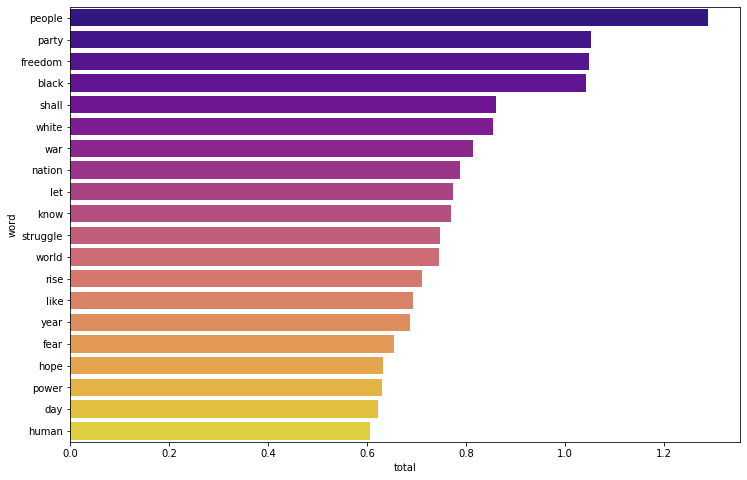

In [156]:
top_inspiring_inaccuracies = count_words(inspiring_inaccurate['speech'],20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_inspiring_inaccuracies, palette='plasma');

In [160]:
# Pick out the correctly predicted ones
inspiring_accurate = model_eval[model_eval['predictions'] == 1]
inspiring_accurate.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brot...,1,1
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely ma...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman c...,1,1
5,Woman’s Rights to the Suffrage by Susan B Anthony,state make sex qualification must ever result disfranchisement one entire half people pas bill attainder ex post facto law therefore violation supreme law land blessing liberty ever withheld woman...,1,1
7,I Have A Dream Speech by Mary Wollstonecraft,say would impress declamation reason offer sober light really capable acting like rational creature let treated like slave like brute dependent reason man associate cultivate mind give salutary su...,1,1


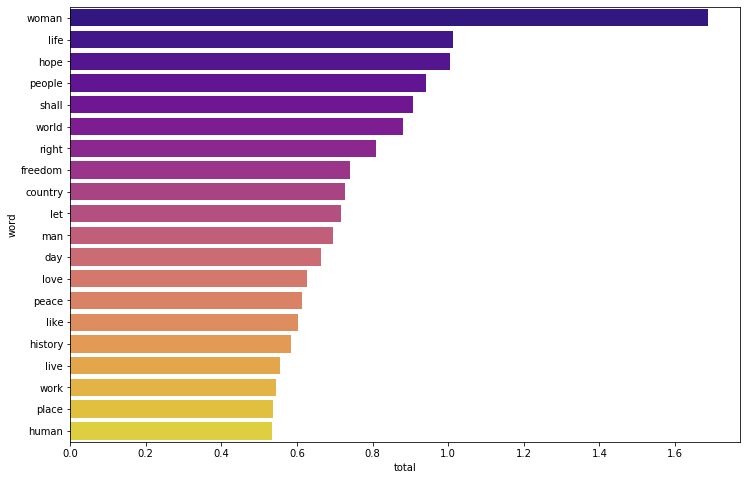

In [161]:
top_inspiring_accuracies = count_words(inspiring_accurate['speech'], 20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_inspiring_accuracies, palette='plasma');

https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14dextract SVM feature importance sklearn sgd

### Unconvincing Classifier Evaluation

For this classifier, we will evaluate it using our original dataset with train/ test split and see the accuracy of the prediction on the test set.

In [1]:
X = ted_model.transcript
y = ted_model.unconvincing_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

NameError: name 'ted_model' is not defined

In [ ]:
test data - get predict proba 

In [ ]:
unconvincing

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

# create plot
plt.figure(figsize=(15, 5))
colors = [‘red’ if c < 0 else ‘blue’ for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha=’right’)
plt.show()

tvec = TfidfVectorizer()
tvec.fit(data)
print len(cv.vocabulary_)
print cv.get_feature_names()
X_train = cv.transform(data)

svm = SGDClassfier()
svm.fit(X_train, target)
plot_coefficients(svm, cv.get_feature_names())

##